# Comparison to Other QSP Methods

In this notebook, we provide example comparisons of the execution time for quantum state preparation task using:

1. Our newly implemented QSP method `.construct_circuit()` using the multi-control Ry gate sequences via Braket

2. Qiskit's build-in `.initialize()` method

3. Braket's `.unitary()` method

<span style="color:red;"> Note: the current comparisons are only done on dense states (i.e., $N = 2^n$). Sparse states (i.e., $d < 2^n$) are benchmarked in https://github.com/guikaiwen/qubit_efficient_QSP/blob/main/performance_benchmark/braket_sparse_state_cost_benchmark.ipynb and https://github.com/guikaiwen/qubit_efficient_QSP/blob/main/performance_benchmark/qiskit_sparse_state_gate_count.ipynb. </span>

In [1]:
import numpy as np

from BenchmarkTime import BenchmarkTime

from helper_functions import nicer_array_display, generate_normalized_complex_array, generate_normalized_real_array, measure_time

We will show the `CPU time` for each QSP method across different size $n$ (real and complex amplitudes), collected from the experiments below with varygin $n$ values.

In [2]:
def generate_time_comparison_arrays(start_qubit_count, end_qubit_count, mode="real"):
        braket_time_arr = []
        qiskit_time_arr = []
        braket_unitary_time_arr = []

        for n in range(start_qubit_count, end_qubit_count + 1):
            if mode == "real":
                input_array = generate_normalized_real_array(n)
            elif mode == "complex":
                input_array = generate_normalized_complex_array(n)
            else:
                print("mode can only be real or complex")
                break
        
            braket_experiment = BenchmarkTime(input_array)
            setup_braket_time = measure_time(braket_experiment, 'setup_braket')
            run_braket_time = measure_time(braket_experiment, 'run_braket')
            braket_time_arr.append(run_braket_time)

            qiskit_experiment = BenchmarkTime(input_array)
            setup_qiskit_time = measure_time(qiskit_experiment, 'setup_qiskit')
            run_qiskit_time = measure_time(qiskit_experiment, 'run_qiskit_statevector')
            qiskit_time_arr.append(run_qiskit_time)

            if (n > 10): # skip large instance for braket unitary
                continue

            braket_unitary_experiment = BenchmarkTime(input_array)
            braket_unitary_experiment.setup_braket()
            setup_braket_unitary_time = measure_time(braket_unitary_experiment, 'setup_braket_unitary')
            run_braket_unitary_time = measure_time(braket_unitary_experiment, 'run_braket_unitary')
            braket_unitary_time_arr.append(run_braket_unitary_time)
            
        return braket_time_arr, qiskit_time_arr, braket_unitary_time_arr

In [3]:
braket_time_arr_real, qiskit_time_arr_real, braket_unitary_time_arr_real = generate_time_comparison_arrays(6, 12, mode = "real")

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[0.007+0.j]
 [0.056+0.j]
 [0.152+0.j]
 [0.19 +0.j]
 [0.213+0.j]
 [0.015+0.j]
 [0.064+0.j]
 [0.01 +0.j]
 [0.02 +0.j]
 [0.01 +0.j]
 [0.094+0.j]
 [0.071+0.j]
 [0.156+0.j]
 [0.002+0.j]
 [0.027+0.j]
 [0.103+0.j]
 [0.163+0.j]
 [0.21 +0.j]
 [0.122+0.j]
 [0.181+0.j]
 [0.077+0.j]
 [0.158+0.j]
 [0.037+0.j]
 [0.186+0.j]
 [0.212+0.j]
 [0.178+0.j]
 [0.097+0.j]
 [0.103+0.j]
 [0.006+0.j]
 [0.216+0.j]
 [0.108+0.j]
 [0.094+0.j]
 [0.163+0.j]
 [0.194+0.j]
 [0.152+0.j]
 [0.036+0.j]
 [0.143+0.j]
 [0.102+0.j]
 [0.103+0.j]
 [0.035+0.j]
 [0.004+0.j]
 [0.12 +0.j]
 [0.053+0.j]
 [0.208+0.j]
 [0.105+0.j]
 [0.114+0.j]
 [0.176+0.j]
 [0.005+0.j]
 [0.146+0.j]
 [0.1  +0.j]
 [0.045+0.j]
 [0.218+0.j]
 [0.103+0.j]
 [0.013+0.j]
 [0.025+0.j]
 [0.18 +0.j]
 [0.003+0.j]
 [0.12 +0.j]
 [0.077+0.j]
 [0.039+0.j]
 [0.146+0.j]
 [0.17 +0.j]
 [0.207+0.j]
 [0.052+0.j]]
[[0.007+0.j]
 [0.056+0.j]
 [0.152+0.j]
 [0.19 +0.j]
 [0.213+0.j]
 [0.015+0.j]
 [0.064+0.j]
 [0.01 +0.j]
 [0.02 +0.j]
 [0.01 +0.j]
 [0.094+0.j]
 [0.071+0.j]
 [0.156+0.j

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[0.014+0.j]
 [0.054+0.j]
 [0.132+0.j]
 [0.051+0.j]
 [0.024+0.j]
 [0.03 +0.j]
 [0.023+0.j]
 [0.11 +0.j]
 [0.052+0.j]
 [0.046+0.j]
 [0.124+0.j]
 [0.015+0.j]
 [0.118+0.j]
 [0.128+0.j]
 [0.032+0.j]
 [0.098+0.j]
 [0.144+0.j]
 [0.018+0.j]
 [0.083+0.j]
 [0.004+0.j]
 [0.044+0.j]
 [0.02 +0.j]
 [0.033+0.j]
 [0.028+0.j]
 [0.133+0.j]
 [0.117+0.j]
 [0.141+0.j]
 [0.138+0.j]
 [0.04 +0.j]
 [0.001+0.j]
 [0.084+0.j]
 [0.091+0.j]
 [0.128+0.j]
 [0.   +0.j]
 [0.142+0.j]
 [0.004+0.j]
 [0.006+0.j]
 [0.072+0.j]
 [0.106+0.j]
 [0.067+0.j]
 [0.052+0.j]
 [0.013+0.j]
 [0.101+0.j]
 [0.022+0.j]
 [0.04 +0.j]
 [0.138+0.j]
 [0.097+0.j]
 [0.135+0.j]
 [0.103+0.j]
 [0.068+0.j]
 [0.09 +0.j]
 [0.032+0.j]
 [0.145+0.j]
 [0.105+0.j]
 [0.132+0.j]
 [0.034+0.j]
 [0.112+0.j]
 [0.064+0.j]
 [0.139+0.j]
 [0.037+0.j]
 [0.041+0.j]
 [0.015+0.j]
 [0.051+0.j]
 [0.066+0.j]
 [0.147+0.j]
 [0.001+0.j]
 [0.152+0.j]
 [0.107+0.j]
 [0.123+0.j]
 [0.11 +0.j]
 [0.101+0.j]
 [0.149+0.j]
 [0.096+0.j]
 [0.14 +0.j]
 [0.001+0.j]
 [0.009+0.j]
 [0.003+0.j]

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[0.106+0.j]
 [0.094+0.j]
 [0.046+0.j]
 [0.091+0.j]
 [0.017+0.j]
 [0.089+0.j]
 [0.013+0.j]
 [0.092+0.j]
 [0.005+0.j]
 [0.039+0.j]
 [0.089+0.j]
 [0.072+0.j]
 [0.054+0.j]
 [0.028+0.j]
 [0.018+0.j]
 [0.069+0.j]
 [0.055+0.j]
 [0.101+0.j]
 [0.03 +0.j]
 [0.039+0.j]
 [0.055+0.j]
 [0.07 +0.j]
 [0.048+0.j]
 [0.098+0.j]
 [0.045+0.j]
 [0.046+0.j]
 [0.011+0.j]
 [0.099+0.j]
 [0.049+0.j]
 [0.069+0.j]
 [0.023+0.j]
 [0.071+0.j]
 [0.107+0.j]
 [0.09 +0.j]
 [0.065+0.j]
 [0.065+0.j]
 [0.015+0.j]
 [0.101+0.j]
 [0.063+0.j]
 [0.073+0.j]
 [0.063+0.j]
 [0.017+0.j]
 [0.01 +0.j]
 [0.105+0.j]
 [0.084+0.j]
 [0.088+0.j]
 [0.089+0.j]
 [0.026+0.j]
 [0.069+0.j]
 [0.071+0.j]
 [0.093+0.j]
 [0.08 +0.j]
 [0.071+0.j]
 [0.013+0.j]
 [0.05 +0.j]
 [0.075+0.j]
 [0.043+0.j]
 [0.067+0.j]
 [0.105+0.j]
 [0.039+0.j]
 [0.084+0.j]
 [0.05 +0.j]
 [0.021+0.j]
 [0.034+0.j]
 [0.047+0.j]
 [0.09 +0.j]
 [0.105+0.j]
 [0.017+0.j]
 [0.048+0.j]
 [0.023+0.j]
 [0.033+0.j]
 [0.006+0.j]
 [0.024+0.j]
 [0.019+0.j]
 [0.037+0.j]
 [0.029+0.j]
 [0.013+0.j]

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[0.073+0.j]
 [0.077+0.j]
 [0.001+0.j]
 [0.012+0.j]
 [0.001+0.j]
 [0.038+0.j]
 [0.014+0.j]
 [0.01 +0.j]
 [0.002+0.j]
 [0.04 +0.j]
 [0.032+0.j]
 [0.002+0.j]
 [0.006+0.j]
 [0.02 +0.j]
 [0.018+0.j]
 [0.057+0.j]
 [0.021+0.j]
 [0.038+0.j]
 [0.071+0.j]
 [0.05 +0.j]
 [0.029+0.j]
 [0.046+0.j]
 [0.056+0.j]
 [0.075+0.j]
 [0.039+0.j]
 [0.064+0.j]
 [0.026+0.j]
 [0.029+0.j]
 [0.01 +0.j]
 [0.055+0.j]
 [0.023+0.j]
 [0.045+0.j]
 [0.074+0.j]
 [0.05 +0.j]
 [0.004+0.j]
 [0.037+0.j]
 [0.055+0.j]
 [0.001+0.j]
 [0.029+0.j]
 [0.021+0.j]
 [0.038+0.j]
 [0.01 +0.j]
 [0.05 +0.j]
 [0.023+0.j]
 [0.003+0.j]
 [0.045+0.j]
 [0.013+0.j]
 [0.044+0.j]
 [0.014+0.j]
 [0.044+0.j]
 [0.071+0.j]
 [0.022+0.j]
 [0.071+0.j]
 [0.062+0.j]
 [0.068+0.j]
 [0.053+0.j]
 [0.008+0.j]
 [0.068+0.j]
 [0.007+0.j]
 [0.028+0.j]
 [0.   +0.j]
 [0.031+0.j]
 [0.028+0.j]
 [0.024+0.j]
 [0.054+0.j]
 [0.044+0.j]
 [0.072+0.j]
 [0.045+0.j]
 [0.051+0.j]
 [0.005+0.j]
 [0.051+0.j]
 [0.018+0.j]
 [0.067+0.j]
 [0.006+0.j]
 [0.07 +0.j]
 [0.073+0.j]
 [0.059+0.j]

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[0.034+0.j]
 [0.026+0.j]
 [0.04 +0.j]
 ...
 [0.018+0.j]
 [0.017+0.j]
 [0.025+0.j]]
[[0.034+0.j]
 [0.026+0.j]
 [0.04 +0.j]
 ...
 [0.018+0.j]
 [0.017+0.j]
 [0.025+0.j]]
[[0.034+0.j]
 [0.026+0.j]
 [0.04 +0.j]
 ...
 [0.018+0.j]
 [0.017+0.j]
 [0.025+0.j]]


This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[0.037+0.j]
 [0.001+0.j]
 [0.025+0.j]
 ...
 [0.036+0.j]
 [0.013+0.j]
 [0.015+0.j]]
[[0.037+0.j]
 [0.001+0.j]
 [0.025+0.j]
 ...
 [0.036+0.j]
 [0.013+0.j]
 [0.015+0.j]]


This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[0.023+0.j]
 [0.012+0.j]
 [0.015+0.j]
 ...
 [0.027+0.j]
 [0.012+0.j]
 [0.001+0.j]]
[[0.023+0.j]
 [0.012+0.j]
 [0.015+0.j]
 ...
 [0.027+0.j]
 [0.012+0.j]
 [0.001+0.j]]


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

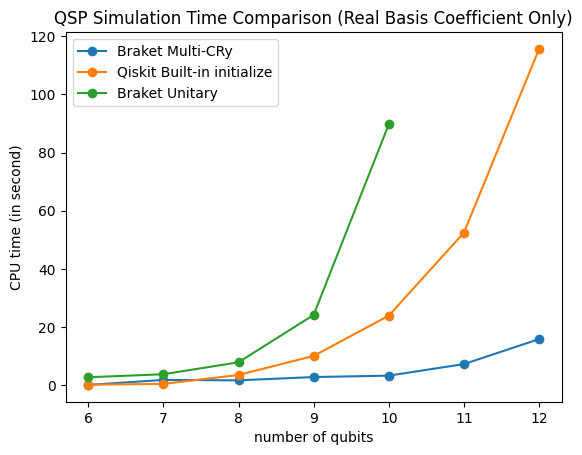

In [5]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
n = 12
x1 = range(6, n + 1)
x2 = range(6, n - 2 + 1)
ax.plot(x1, braket_time_arr_real, label='Braket Multi-CRy', marker='o')
ax.plot(x1, qiskit_time_arr_real, label='Qiskit Built-in initialize', marker='o')
ax.plot(x2, braket_unitary_time_arr_real, label='Braket Unitary', marker='o')
ax.set_xlabel('number of qubits')  # Add an x-label to the axes.
ax.set_ylabel('CPU time (in second)')  # Add a y-label to the axes.
ax.set_title("QSP Simulation Time Comparison (Real Basis Coefficient Only)")
ax.legend()  # Add a legend.

(Note that the Braket Unitary time for n = 11 and n = 12 is not report due to their longer time)

<span style="color:orange;"> Note: the actual CPU time for each data point will have slight variations. </span>

In [6]:
braket_time_arr, qiskit_time_arr, braket_unitary_time_arr = generate_time_comparison_arrays(6, 12, mode = "complex")

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[ 0.1  +0.036j]
 [-0.046+0.026j]
 [-0.032-0.123j]
 [ 0.089-0.065j]
 [ 0.122-0.019j]
 [-0.023-0.045j]
 [ 0.065+0.123j]
 [-0.043+0.059j]
 [ 0.133-0.07j ]
 [-0.046+0.09j ]
 [ 0.003-0.111j]
 [-0.121+0.055j]
 [ 0.135-0.12j ]
 [ 0.017+0.067j]
 [ 0.076+0.051j]
 [ 0.047+0.073j]
 [-0.108-0.024j]
 [ 0.113-0.102j]
 [ 0.003+0.063j]
 [-0.115+0.032j]
 [ 0.133-0.128j]
 [-0.125-0.032j]
 [ 0.003+0.076j]
 [ 0.086+0.116j]
 [ 0.105+0.134j]
 [-0.059+0.102j]
 [ 0.053+0.125j]
 [-0.129-0.098j]
 [ 0.089+0.068j]
 [ 0.04 +0.067j]
 [-0.092-0.146j]
 [-0.118-0.132j]
 [ 0.07 -0.063j]
 [-0.02 -0.147j]
 [ 0.041-0.077j]
 [ 0.147-0.032j]
 [-0.098-0.05j ]
 [-0.069+0.08j ]
 [-0.067-0.13j ]
 [ 0.073+0.056j]
 [ 0.03 -0.111j]
 [-0.143+0.001j]
 [ 0.073+0.009j]
 [ 0.057-0.088j]
 [-0.142+0.098j]
 [-0.111-0.077j]
 [ 0.079-0.041j]
 [-0.126-0.068j]
 [-0.094-0.13j ]
 [-0.1  +0.08j ]
 [ 0.126+0.047j]
 [ 0.01 +0.056j]
 [-0.159+0.099j]
 [-0.068+0.096j]
 [ 0.116-0.109j]
 [-0.056+0.115j]
 [ 0.134-0.069j]
 [-0.133-0.097j]
 [-0.112-0.086

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[-0.099-0.023j]
 [-0.047-0.037j]
 [ 0.04 +0.03j ]
 [-0.024-0.076j]
 [-0.102+0.073j]
 [ 0.057+0.087j]
 [ 0.019-0.075j]
 [ 0.035+0.045j]
 [ 0.006+0.098j]
 [ 0.014-0.043j]
 [ 0.013+0.095j]
 [-0.028+0.013j]
 [ 0.031+0.j   ]
 [ 0.028-0.053j]
 [ 0.037+0.069j]
 [ 0.023-0.038j]
 [ 0.083+0.074j]
 [ 0.086+0.066j]
 [-0.089-0.081j]
 [-0.044+0.084j]
 [ 0.   -0.013j]
 [-0.086+0.033j]
 [ 0.008-0.082j]
 [-0.037-0.018j]
 [ 0.085+0.07j ]
 [-0.002+0.085j]
 [ 0.012-0.071j]
 [ 0.044+0.027j]
 [-0.084-0.058j]
 [-0.063+0.063j]
 [-0.042-0.046j]
 [-0.037-0.074j]
 [-0.007-0.076j]
 [-0.076+0.026j]
 [-0.022-0.029j]
 [ 0.077-0.031j]
 [-0.032+0.017j]
 [ 0.053-0.025j]
 [ 0.101-0.1j  ]
 [ 0.031+0.104j]
 [-0.044-0.059j]
 [-0.003+0.077j]
 [-0.015+0.104j]
 [-0.02 -0.07j ]
 [-0.007+0.078j]
 [-0.03 -0.006j]
 [-0.005+0.014j]
 [ 0.106+0.02j ]
 [ 0.11 -0.08j ]
 [ 0.071-0.066j]
 [ 0.002+0.j   ]
 [-0.067-0.096j]
 [-0.013+0.016j]
 [ 0.073+0.056j]
 [-0.068-0.058j]
 [ 0.079-0.074j]
 [-0.107+0.001j]
 [-0.097+0.014j]
 [ 0.015-0.063

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[ 0.065-0.054j]
 [-0.05 -0.063j]
 [-0.059+0.017j]
 [-0.041-0.074j]
 [-0.008-0.02j ]
 [-0.062+0.051j]
 [-0.068-0.015j]
 [ 0.063-0.021j]
 [ 0.05 -0.019j]
 [ 0.063-0.053j]
 [ 0.06 -0.04j ]
 [ 0.011+0.02j ]
 [-0.059+0.026j]
 [ 0.073+0.016j]
 [ 0.026+0.035j]
 [ 0.047+0.008j]
 [-0.054-0.038j]
 [-0.061-0.065j]
 [ 0.056+0.j   ]
 [ 0.074+0.062j]
 [-0.038+0.004j]
 [ 0.002+0.056j]
 [-0.07 -0.064j]
 [ 0.012-0.028j]
 [-0.033-0.055j]
 [ 0.004-0.07j ]
 [ 0.062+0.003j]
 [-0.054+0.021j]
 [ 0.007-0.046j]
 [-0.033-0.039j]
 [ 0.035+0.022j]
 [ 0.061-0.059j]
 [ 0.066+0.062j]
 [-0.031+0.014j]
 [ 0.052-0.022j]
 [-0.057+0.015j]
 [ 0.058-0.051j]
 [-0.048-0.072j]
 [ 0.069-0.001j]
 [-0.004-0.058j]
 [ 0.018+0.022j]
 [-0.031-0.018j]
 [ 0.045+0.044j]
 [ 0.027+0.018j]
 [-0.009-0.j   ]
 [-0.048+0.025j]
 [ 0.067+0.009j]
 [ 0.012+0.066j]
 [-0.043+0.056j]
 [-0.049+0.018j]
 [ 0.   -0.069j]
 [-0.064-0.019j]
 [-0.005-0.011j]
 [-0.03 -0.054j]
 [-0.009+0.011j]
 [ 0.042-0.05j ]
 [ 0.05 +0.005j]
 [-0.051-0.007j]
 [ 0.008-0.054

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[ 0.047-0.022j]
 [ 0.012+0.014j]
 [-0.03 +0.003j]
 [ 0.032+0.044j]
 [-0.016+0.052j]
 [ 0.016+0.04j ]
 [ 0.025+0.035j]
 [-0.039-0.053j]
 [-0.02 -0.031j]
 [ 0.021+0.041j]
 [ 0.041-0.028j]
 [-0.022+0.021j]
 [-0.036-0.035j]
 [ 0.01 -0.002j]
 [-0.043-0.029j]
 [-0.025+0.048j]
 [ 0.005-0.034j]
 [ 0.013+0.026j]
 [ 0.041+0.016j]
 [-0.029-0.02j ]
 [ 0.034-0.017j]
 [ 0.024+0.052j]
 [ 0.016+0.022j]
 [-0.04 -0.055j]
 [ 0.049-0.038j]
 [-0.021+0.023j]
 [ 0.021+0.043j]
 [ 0.014-0.044j]
 [ 0.043+0.002j]
 [-0.035-0.014j]
 [ 0.   -0.001j]
 [ 0.006+0.j   ]
 [ 0.017-0.001j]
 [ 0.016-0.049j]
 [-0.033+0.013j]
 [-0.046-0.033j]
 [-0.005-0.025j]
 [ 0.034+0.03j ]
 [-0.038+0.025j]
 [-0.038-0.034j]
 [ 0.015-0.038j]
 [ 0.012-0.012j]
 [-0.042+0.025j]
 [-0.007+0.047j]
 [-0.025+0.047j]
 [-0.046+0.007j]
 [ 0.053+0.006j]
 [ 0.028-0.028j]
 [-0.049-0.036j]
 [-0.039+0.034j]
 [-0.041-0.03j ]
 [-0.015+0.002j]
 [ 0.049-0.003j]
 [-0.042-0.021j]
 [ 0.037-0.002j]
 [ 0.04 -0.029j]
 [ 0.033+0.018j]
 [-0.021-0.044j]
 [ 0.025-0.015

This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[-0.013+0.036j]
 [ 0.023-0.004j]
 [ 0.028+0.015j]
 ...
 [ 0.016-0.015j]
 [-0.033+0.002j]
 [ 0.025-0.018j]]
[[-0.013+0.035j]
 [ 0.024-0.004j]
 [ 0.027+0.015j]
 ...
 [ 0.016-0.015j]
 [-0.033+0.002j]
 [ 0.025-0.018j]]
[[-0.013+0.036j]
 [ 0.023-0.004j]
 [ 0.028+0.015j]
 ...
 [ 0.016-0.015j]
 [-0.033+0.002j]
 [ 0.025-0.018j]]


This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[ 0.013+0.009j]
 [-0.005-0.021j]
 [-0.003-0.018j]
 ...
 [-0.007+0.012j]
 [-0.007+0.018j]
 [-0.01 -0.013j]]
[[ 0.013+0.008j]
 [-0.005-0.021j]
 [-0.004-0.018j]
 ...
 [-0.006+0.013j]
 [-0.006+0.018j]
 [-0.01 -0.013j]]


This program uses OpenQASM language features that may not be supported on QPUs or on-demand simulators.


[[-0.009+0.006j]
 [-0.002+0.002j]
 [ 0.009+0.016j]
 ...
 [ 0.002+0.007j]
 [ 0.013+0.007j]
 [ 0.017-0.003j]]
[[-0.009+0.006j]
 [-0.002+0.002j]
 [ 0.009+0.016j]
 ...
 [ 0.002+0.007j]
 [ 0.013+0.007j]
 [ 0.017-0.003j]]


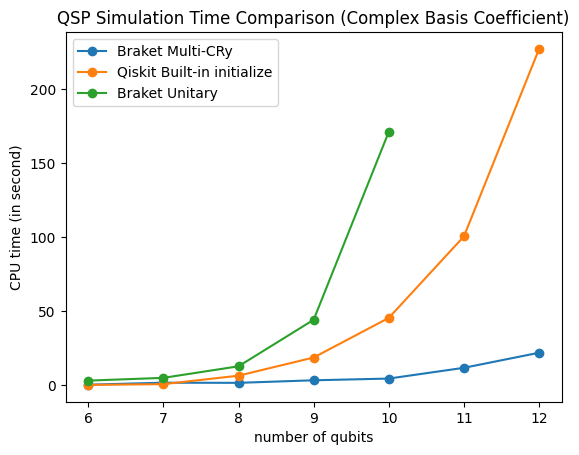

In [7]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
n = 12
x1 = range(6, n + 1)
x2 = range(6, n - 2 + 1)
ax.plot(x1, braket_time_arr, label='Braket Multi-CRy', marker='o')
ax.plot(x1, qiskit_time_arr, label='Qiskit Built-in initialize', marker='o')
ax.plot(x2, braket_unitary_time_arr, label='Braket Unitary', marker='o')
ax.set_xlabel('number of qubits')  # Add an x-label to the axes.
ax.set_ylabel('CPU time (in second)')  # Add a y-label to the axes.
ax.set_title("QSP Simulation Time Comparison (Complex Basis Coefficient)")
ax.legend()  # Add a legend.

(Note that the Braket Unitary time for n = 11 and n = 12 is not report due to their longer time)